In [29]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [30]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

dataTraining = dataTraining.drop_duplicates()
dataTraining['plot'] = dataTraining['title'] + ' ' + dataTraining['plot']
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [31]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,Most most is the story of a single father who ...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,How to Be a Serial Killer a serial killer deci...,"[Comedy, Crime, Horror]",5.6
6724,1941,A Woman's Face,"A Woman's Face in sweden , a female blackmail...","[Drama, Film-Noir, Thriller]",7.2
4704,1954,Executive Suite,Executive Suite in a friday afternoon in new y...,[Drama],7.4
2582,1990,Narrow Margin,"Narrow Margin in los angeles , the editor of ...","[Action, Crime, Thriller]",6.6


In [32]:
max_f = 2500
test_size = 0.2
random_state = 42

def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

In [33]:
from nltk.corpus import stopwords

# Initialize a list of custom stop words
custom_stop_words = ['jack', 'john', 'doe', 'york', 'year old',  'also', 'one', 
                     'two', 'three', 'becomes', 'another', 'nick', 'charlie', 
                     'david', 'sam', 'frank', 'four', 'joe', 'tom', 'michael', 
                     'george', 'may',
                     ]   #, 'get' 'year' 

# Combine custom stop words with the default English stop words
all_stop_words = stopwords.words('english') + custom_stop_words

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', lowercase = True, 
                             tokenizer=tokenize, stop_words=all_stop_words, max_features=100,
                             strip_accents='unicode', use_idf=True, min_df=10)

# vectorizer = CountVectorizer(ngram_range=(1, 2), 
#                              preprocessor=preprocess_text, 
#                              stop_words="english", 
#                              max_features=100)

In [35]:
X = vectorizer.fit_transform(dataTraining['plot'])
print(X.shape)

(7894, 100)


In [36]:
l = vectorizer.get_feature_names_out().tolist()
l = [x.replace('_',' ') for x in l]

In [37]:
p = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
p['suma'] = p.sum(axis=1)
p = p[p['suma'] != 0]
p.drop(['suma'], axis=1, inplace=True)
p.head()

,american,away,back,become,begin,belief,best,boy,brother,car,...,way,well,wife,woman,work,world,would,year,year old,young
0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.347064,0.0,0.0,...,0.000000,0.0,0.000000,0.289534,0.20025,0.0,0.0,0.083133,0.122302,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.000000,0.280263,0.0,0.29203,0.0,0.000000,0.0,0.0,...,0.231001,0.0,0.234297,0.457094,0.00000,0.0,0.0,0.196865,0.289622,0.0
3,0.0,0.0,0.201091,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0


In [38]:
p.shape

(7821, 100)

In [39]:
# sns.kdeplot(data=p, x="suma")

In [40]:
p.shape

(7821, 100)

In [41]:
contador = p.sum()
contador = contador.sort_values(ascending=False)
contador.head()

life    593.458392
find    480.944012
get     438.947284
new     417.251212
man     399.452312
dtype: float64

In [42]:
# cooccurrence matrix 
cooccurrence_matrix = np.dot(p.transpose(),p)
# print('\ncooccurrence_matrix:\n{0}'.format(cooccurrence_matrix)) 

In [43]:
cooccurrence_matrix.shape

(100, 100)

In [44]:
# ax = sns.heatmap(cooccurrence_matrix, xticklabels=vectorizer.get_feature_names_out(), yticklabels=vectorizer.get_feature_names_out())

In [45]:
transformer = TfidfTransformer(norm="l2", smooth_idf=False)
idf = pd.DataFrame(transformer.fit_transform(cooccurrence_matrix).toarray(), columns=l)
idf.head()

,american,away,back,become,begin,belief,best,boy,brother,car,...,way,well,wife,woman,work,world,would,year,year old,young
0,0.854777,0.017713,0.063254,0.058162,0.043128,0.036100,0.030696,0.031307,0.042373,0.027569,...,0.059063,0.040200,0.055166,0.067688,0.069012,0.083008,0.035676,0.056955,0.015956,0.083439
1,0.030145,0.712920,0.098455,0.040583,0.044522,0.040652,0.042813,0.064080,0.046763,0.056174,...,0.076136,0.046180,0.083802,0.076661,0.075524,0.074455,0.054319,0.110646,0.037844,0.076778
2,0.055523,0.050781,0.719283,0.044235,0.063445,0.042205,0.052894,0.044723,0.047596,0.044613,...,0.105965,0.040247,0.090981,0.074723,0.066702,0.081562,0.043364,0.102869,0.029156,0.073472
3,0.084364,0.034590,0.073099,0.752330,0.058206,0.047438,0.050967,0.050584,0.047189,0.019828,...,0.061692,0.033958,0.075194,0.086510,0.084780,0.094419,0.055029,0.101497,0.038155,0.093984
4,0.048167,0.029218,0.080724,0.044816,0.777227,0.039446,0.043947,0.041407,0.044930,0.041612,...,0.070137,0.048472,0.068670,0.097870,0.068230,0.092140,0.044359,0.092267,0.031280,0.071822


In [46]:
idf.shape

(100, 100)

In [47]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
fm = pd.DataFrame(svd.fit_transform(idf), columns=['x','y'])
fm['words'] = l
fm['words'] = fm['words'].str.capitalize()
fm.head()

,x,y,words
0,0.551455,-0.296861,American
1,0.735097,0.063577,Away
2,0.759587,-0.032706,Back
3,0.698663,-0.079835,Become
4,0.683983,-0.065798,Begin


In [48]:
# contador = p.sum()
# con = pd.DataFrame(contador, columns=['Contador']).reset_index()
# con = con.rename(columns={'index': 'words'})
# con.head()

In [49]:
# df_mar = pd.merge(fm, con, on='words')
# df_mar['words'] = df_mar['words'].str.capitalize()
# df_mar.head()

In [50]:
labels={'x':'X-Axis Label',
        'y':'Y-Axis Label',
        'words':'Word',
        'group':'Group'
    }

In [51]:
fig = px.scatter(fm, x="x", y="y", text="words", 
                 size_max=100, color="words", 
                 labels=labels)

# Customize text positioning (consider clarity and visual balance)
fig.update_traces(textposition='top center')  # or 'top center' based on preference

# Informative layout with custom title
fig.update_layout(
    title_text='Cloud <br><sup> Describe the movies in 100 words </sup>',  # Title
    title_x=0.5,  # Centered title
    xaxis_title=' ',  # Add meaningful axis labels
    yaxis_title=' ',
    font=dict(family="Arial", size=12),  # Consistent font style and size
    plot_bgcolor='white',  # Clean background color
    xaxis_tickformat='.2f',  # Format x-axis ticks for readability (adjust as needed)
    yaxis_tickformat='.2f',  # Format y-axis ticks for readability (adjust as needed)

    xaxis=dict(
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        ticks='',
        showticklabels=False
    )

)

# Interactive elements (optional)
fig.update_layout(hovermode='closest')  # Hover over a point for details
fig.update_traces(opacity=0.8)  # Adjust marker opacity for better visibility

# Advanced styling (optional)
fig.update_xaxes(showline=False, linewidth=2, linecolor='gray')  # X-axis formatting
fig.update_yaxes(showline=False, linewidth=2, linecolor='gray')  # Y-axis formatting

# Save
fig.write_html('{}.html'.format('cloud'))

# Display the enhanced plot
fig.show()

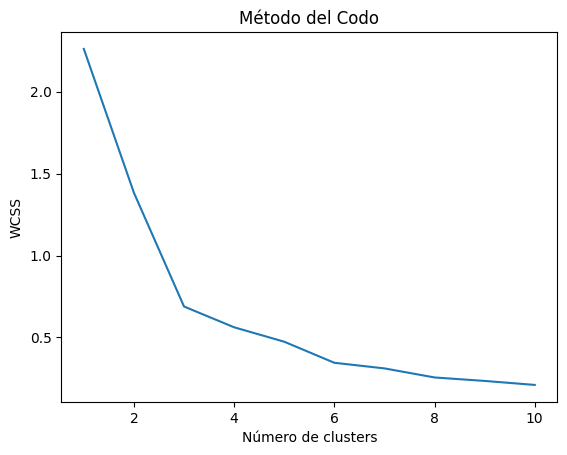

In [52]:
wcss = []

# Probar diferentes valores de k
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(fm.loc[:,['x', 'y']])
    wcss.append(kmeans.inertia_)


# Graficar el método del codo
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()

In [53]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
fm['group'] = kmeans.fit_predict(fm.loc[:,['x', 'y']])
fm['group'] = fm['group'].astype(str)
fm.head()

,x,y,words,group
0,0.551455,-0.296861,American,2
1,0.735097,0.063577,Away,5
2,0.759587,-0.032706,Back,0
3,0.698663,-0.079835,Become,0
4,0.683983,-0.065798,Begin,0


In [54]:
fig = px.scatter(fm, x="x", y="y", text="words", 
                 size_max=100, color="group", 
                 category_orders={'group': ['0', '1', '2', '3', '4', '5', '6', '7']},
                 labels=labels)

# Customize text positioning (consider clarity and visual balance)
fig.update_traces(textposition='top center')  # or 'top center' based on preference

# Informative layout with custom title
fig.update_layout(
    title_text='Cloud <br><sup> Describe the movies in 100 words by groups </sup>',  # Title
    title_x=0.5,  # Centered title
    xaxis_title=' ',  # Add meaningful axis labels
    yaxis_title=' ',
    font=dict(family="Arial", size=12),  # Consistent font style and size
    plot_bgcolor='white',  # Clean background color
    xaxis_tickformat='.2f',  # Format x-axis ticks for readability (adjust as needed)
    yaxis_tickformat='.2f',  # Format y-axis ticks for readability (adjust as needed)

    xaxis=dict(
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        ticks='',
        showticklabels=False
    )

)

# Interactive elements (optional)
fig.update_layout(hovermode='closest')  # Hover over a point for details
fig.update_traces(opacity=0.8)  # Adjust marker opacity for better visibility

# Advanced styling (optional)
fig.update_xaxes(showline=False, linewidth=2, linecolor='gray')  # X-axis formatting
fig.update_yaxes(showline=False, linewidth=2, linecolor='gray')  # Y-axis formatting

# Save
fig.write_html('{}.html'.format('cloud2'))

# Display the enhanced plot
fig.show()

In [58]:
# from sklearn.mixture import GaussianMixture

In [59]:
# #
# # Numero de componentes
# #
# n_components = np.arange(1, 10)

# gaussianModels = [
#     GaussianMixture(n, covariance_type="full", random_state=42).fit(fm.loc[:,['x', 'y']])
#     for n in n_components
# ]

In [60]:
# #
# # Método de codo con AIC y BIC
# #
# plt.figure(figsize=(10, 5))
# plt.plot(n_components, [model.bic(fm.loc[:,['x', 'y']]) for model in gaussianModels], "o-", label="BIC")
# plt.plot(n_components, [model.aic(fm.loc[:,['x', 'y']]) for model in gaussianModels], "o-", label="AIC")
# plt.legend(loc="best")
# plt.xlabel("Número de componentes")
# plt.gca().spines["left"].set_color("gray")
# plt.gca().spines["bottom"].set_color("gray")
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)
# plt.show()

In [61]:
# #
# # Ajuste de modelo GMM
# #
# n_components = 7
# gaussianMixture = GaussianMixture(
#     n_components=n_components,
#     covariance_type="full",
#     max_iter=100,
#     init_params="kmeans",
# )

# mixture = gaussianMixture.fit(fm.loc[:,['x', 'y']])
# fm['group'] = mixture.fit_predict(fm.loc[:,['x', 'y']])
# fm['group'] = fm['group'].astype(str)
# fm.head()

In [62]:
# fig = px.scatter(fm, x="x", y="y", text="words", 
#                  size_max=100, color="group", 
#                  category_orders={'group': ['0', '1', '2', '3', '4', '5', '6', '7']},
#                  labels=labels)

# # Customize text positioning (consider clarity and visual balance)
# fig.update_traces(textposition='top center')  # or 'top center' based on preference

# # Informative layout with custom title
# fig.update_layout(
#     title_text='Cloud <br><sup> Describe the movies in 100 words by groups </sup>',  # Title
#     title_x=0.5,  # Centered title
#     xaxis_title='X-Axis Label',  # Add meaningful axis labels
#     yaxis_title='Y-Axis Label',
#     font=dict(family="Arial", size=12),  # Consistent font style and size
#     plot_bgcolor='white',  # Clean background color
#     xaxis_tickformat='.2f',  # Format x-axis ticks for readability (adjust as needed)
#     yaxis_tickformat='.2f',  # Format y-axis ticks for readability (adjust as needed)
# )

# # Interactive elements (optional)
# fig.update_layout(hovermode='closest')  # Hover over a point for details
# fig.update_traces(opacity=0.8)  # Adjust marker opacity for better visibility

# # Advanced styling (optional)
# fig.update_xaxes(showline=True, linewidth=2, linecolor='gray')  # X-axis formatting
# fig.update_yaxes(showline=True, linewidth=2, linecolor='gray')  # Y-axis formatting

# # Save
# fig.write_html('{}.html'.format('cloud2'))

# # Display the enhanced plot
# fig.show()

In [63]:
print('ok_')

ok_
